## 3. Defining a Causal Model

The third step is to construct a causal model that involves identifying the relationships between variables to understand how they influence Exam_Score. 
This will be achieved by creating a Directed Acyclic Graph (DAG) that visually represents these relationships.

### Imports

In [19]:
# Imports
from graphviz import Digraph
import dowhy
from dowhy import CausalModel
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from statsmodels.api import OLS, add_constant
import matplotlib.pyplot as plt

%matplotlib inline

### Load the preprocessed Dataset

In [8]:
df_encoded = pd.read_csv('../data/encoded_student_performance_factors.csv')

### Identify Potential Causal Relationships

##### To construct a causal model, we need to identify which variables might causally influence the exam_score. For example:
- Hours studied (hours_studied): The amount of time a student dedicates to studying is likely to have a direct effect on their exam performance.
- Attendance (attendance): Regular class attendance may positively impact understanding and retention of course material, thereby affecting exam scores.
- Previous Scores (previous_scores): Past academic performance can be an indicator of future success, suggesting a causal link to current exam scores.
- Parental Education Level (parental_education_level): The educational background of parents might influence a student's academic achievements through support and resources.
- Extracurricular Activities (extracurricular_activities): Participation in extracurricular activities could impact study time and focus, potentially affecting exam performance.

### Constructing the Causal Graph (DAG)
visualizes the causal structure

In [9]:
# Initialize a directed graph
dot = Digraph()

# Add nodes
dot.node('A', 'Attendance')
dot.node('H', 'Hours Studied')
dot.node('P', 'Parental Education Level')
dot.node('E', 'Extracurricular Activities')
dot.node('G', 'Previous Scores')
dot.node('X', 'Exam Score')

# Add edges representing causal relationships
dot.edge('A', 'X', label='direct')
dot.edge('H', 'X', label='direct')
dot.edge('P', 'H', label='indirect')
dot.edge('P', 'A', label='indirect')
dot.edge('E', 'H', label='indirect')
dot.edge('G', 'X', label='direct')

# Render the graph
dot.render('../causal-model/causal_model', format='png', cleanup=False)

'..\\causal-model\\causal_model.png'

### Identifying Confounders Using the Back-Door Criterion
Confounders are variables that influence both the treatment (or exposure) and the outcome, potentially biasing the estimated effect. The Back-Door Criterion is a graphical method used to identify such confounders in your DAG. A set of variables satisfies the Back-Door Criterion if, when conditioned upon, it blocks all back-door paths from the treatment to the outcome. Back-door paths are routes in the DAG that start with an arrow pointing into the treatment variable.

It's essential to ensure that the model assumptions hold:
- No Unmeasured Confounders: All confounders must be measured and included in the model.
- Correct Model Specification: The functional form of the model should accurately represent the true relationships between variables.
  
-> Verifying these assumptions often requires domain knowledge and may involve sensitivity analyses to assess the robustness of your findings.

In [10]:
# Define the causal model
model = CausalModel(
    data=df_encoded,
    treatment='Hours_Studied',
    outcome='Exam_Score',
    common_causes=['Parental_Education_Level', 'Attendance', 'Previous_Scores']  # Identified confounders
)

# Identify the causal effect
identified_estimand = model.identify_effect()

# Estimate the causal effect using regression adjustment
estimate = model.estimate_effect(identified_estimand, method_name="backdoor.linear_regression")

# Display the results
print(estimate)


*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                                                                       ↪
────────────────(E[Exam_Score|Attendance,Previous_Scores,Parental_Education_Le ↪
d[Hours_Studied]                                                               ↪

↪      
↪ vel])
↪      
Estimand assumption 1, Unconfoundedness: If U→{Hours_Studied} and U→Exam_Score then P(Exam_Score|Hours_Studied,Attendance,Previous_Scores,Parental_Education_Level,U) = P(Exam_Score|Hours_Studied,Attendance,Previous_Scores,Parental_Education_Level)

## Realized estimand
b: Exam_Score~Hours_Studied+Attendance+Previous_Scores+Parental_Education_Level
Target units: ate

## Estimate
Mean value: 0.29089376320155225



C:\Users\michi\anaconda3\envs\master-thesis-prototyp\Lib\site-packages\dowhy\causal_estimators\regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


### Selecting a Causal Inference Method

#### Several methods are available for estimating causal effects, each with its assumptions and suitability depending on your data and research context. Common approaches include:
- Regression Adjustment: Incorporates confounders as covariates in a regression model to isolate the effect of the treatment.
- Propensity Score Matching (PSM): Matches treated and untreated subjects with similar propensity scores—the probability of receiving the treatment given the confounders—to balance the groups.
- Inverse Probability Weighting (IPW): Weights subjects by the inverse of their probability of receiving the treatment to create a pseudo-population where treatment assignment is independent of confounders.
- Instrumental Variables (IV): Utilizes variables (instruments) that affect the treatment but have no direct effect on the outcome, helping to address unmeasured confounding.


#### For illustration, let's implement the Inverse Probability Weighting (IPW) method using Python. IPW helps to adjust for confounders by weighting each subject by the inverse of the probability of receiving the treatment they actually received.

#### Assumptions for IPW:
- No Unmeasured Confounders: All variables that influence both the treatment and the outcome are measured and included in the model.
- Positivity: Every subject has a non-zero probability of receiving each treatment level.

#### Steps to Implement IPW:
-  Estimate Propensity Scores: Calculate the probability of each subject receiving the treatment (hours_studied) given the confounders (parental_education_level, attendance, previous_scores).
-  Compute Weights: Determine the inverse probability weights based on the propensity scores.
-  Apply Weights in Outcome Model: Use the weights in a weighted regression model to estimate the causal effect of the treatment on the outcome

In [11]:
# Define a threshold for treatment (e.g., median split or 5 hours)
threshold = df_encoded['Hours_Studied'].median()

# Create a binary treatment variable
df_encoded['treatment'] = (df_encoded['Hours_Studied'] >= threshold).astype(int)

# Verify control and treated groups
print(df_encoded['treatment'].value_counts())

treatment
1    3402
0    2976
Name: count, dtype: int64


In [12]:
# Define the treatment and outcome
treatment = 'Hours_Studied'
outcome = 'Exam_Score'

# Define confounders
confounders = ['Parental_Education_Level', 'Attendance', 'Previous_Scores']

# Step 1: Estimate Propensity Scores using the binary treatment
logistic = LogisticRegression()
logistic.fit(df_encoded[confounders], df_encoded['treatment'])

# Predict propensity scores
df_encoded['propensity_score'] = logistic.predict_proba(df_encoded[confounders])[:, 1]

# Step 2: Compute Inverse Probability Weights
df_encoded['weight'] = np.where(
    df_encoded['treatment'] == 1,
    1 / df_encoded['propensity_score'],
    1 / (1 - df_encoded['propensity_score'])
)

# Step 3: Apply Weights in Outcome Model
# Add a constant to the model for the intercept
X = add_constant(df_encoded[treatment])

# Fit a weighted least squares regression model
weighted_model = OLS(df_encoded[outcome], X, weights=df_encoded['weight']).fit()

# Display the results
print(weighted_model.summary())

                            OLS Regression Results                            
Dep. Variable:             Exam_Score   R-squared:                       0.599
Model:                            OLS   Adj. R-squared:                  0.599
Method:                 Least Squares   F-statistic:                     9529.
Date:                Sun, 23 Feb 2025   Prob (F-statistic):               0.00
Time:                        11:43:18   Log-Likelihood:                -17049.
No. Observations:                6378   AIC:                         3.410e+04
Df Residuals:                    6376   BIC:                         3.412e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            61.4372      0.153    401.704

C:\Users\michi\anaconda3\envs\master-thesis-prototyp\Lib\site-packages\statsmodels\regression\linear_model.py:920: ValueWarning: Weights are not supported in OLS and will be ignoredAn exception will be raised in the next version.
  warnings.warn(msg, ValueWarning)
C:\Users\michi\anaconda3\envs\master-thesis-prototyp\Lib\site-packages\statsmodels\base\model.py:130: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)


### Assessing Covariate Balance

Before estimating causal effects, it's crucial to ensure that the treatment and control groups are comparable concerning observed covariates. This comparability, known as covariate balance, indicates that the groups are similar, reducing potential confounding biases.
- Standardized Mean Differences (SMD): Calculate the SMD for each covariate before and after applying weighting or matching techniques. An SMD less than 0.1 typically suggests a negligible difference between groups.
- Visual Diagnostics: Utilize plots such as histograms or box plots to visually inspect the distribution of covariates across groups.

treatment
1    3402
0    2976
Name: count, dtype: int64
Treated count: 3402, Control count: 2976
Sum of treated weights: 6377.981712940681
Sum of control weights: 6378.0115040199635


<Figure size 800x500 with 0 Axes>

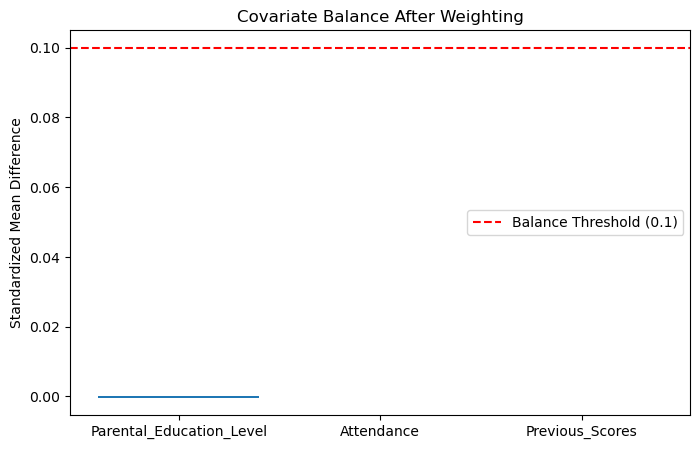

In [13]:
# Define covariates
covariates = ['Parental_Education_Level', 'Attendance', 'Previous_Scores']

# Check treated and control groups
treated = df_encoded[df_encoded['treatment'] == 1]
control = df_encoded[df_encoded['treatment'] == 0]

# Define a threshold for treatment (e.g., median split or 5 hours)
threshold = df_encoded['Hours_Studied'].median()

# Create a binary treatment variable
df_encoded['treatment'] = (df_encoded['Hours_Studied'] >= threshold).astype(int)

# Verify control and treated groups
print(df_encoded['treatment'].value_counts())

# Print counts to debug
print(f"Treated count: {treated.shape[0]}, Control count: {control.shape[0]}")

# Fix Zero Weight Issues
df_encoded['propensity_score'] = np.clip(df_encoded['propensity_score'], 0.01, 0.99)
df_encoded['weight'] = np.where(
    df_encoded['Hours_Studied'] == 1,
    1 / df_encoded['propensity_score'],
    1 / (1 - df_encoded['propensity_score'])
)

# Ensure weights are nonzero
df_encoded['weight'] = np.clip(df_encoded['weight'], 0.01, 10)

# Print sum of weights
print(f"Sum of treated weights: {treated['weight'].sum()}")
print(f"Sum of control weights: {control['weight'].sum()}")

# If still zero, raise an error
if control['weight'].sum() == 0:
    raise ValueError("No valid control group weights! Adjust propensity score model.")

if treated['weight'].sum() == 0:
    raise ValueError("No valid treated group weights! Adjust propensity score model.")

# Calculate Standardized Mean Differences (SMDs)
smd = {}
for covariate in covariates:
    treated_mean = np.average(treated[covariate], weights=treated['weight'])
    control_mean = np.average(control[covariate], weights=control['weight'])
    pooled_std = np.sqrt((np.var(treated[covariate], ddof=1) + np.var(control[covariate], ddof=1)) / 2)
    smd[covariate] = (treated_mean - control_mean) / pooled_std

# Plot SMDs
plt.bar(smd.keys(), smd.values())
plt.axhline(y=0.1, color='r', linestyle='--', label='Balance Threshold (0.1)')
plt.ylabel('Standardized Mean Difference')
plt.title('Covariate Balance After Weighting')
plt.legend()
plt.show()


### Check Overlap Assumption

This ensures the treated and control groups have enough common propensity score support.

Expected Outcome:
- Good Overlap: Both groups have a significant presence across the score range.
- Bad Overlap: If treated and control groups barely overlap, the IPW estimator might be biased.

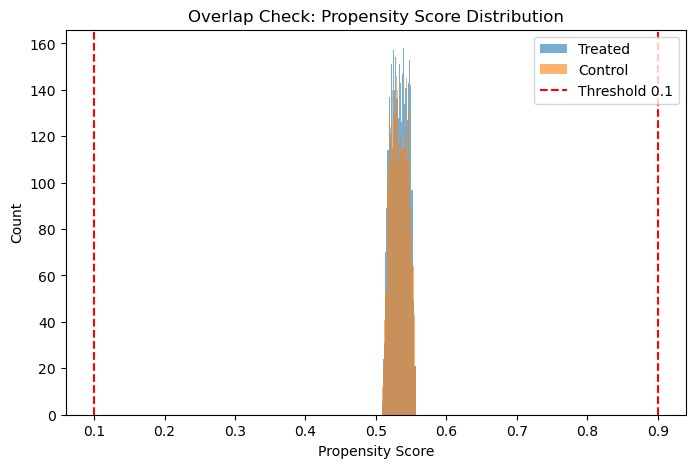

In [14]:
# Plot histogram of propensity scores for treated vs. control
plt.figure(figsize=(8, 5))
plt.hist(df_encoded[df_encoded['treatment'] == 1]['propensity_score'], bins=30, alpha=0.6, label='Treated')
plt.hist(df_encoded[df_encoded['treatment'] == 0]['propensity_score'], bins=30, alpha=0.6, label='Control')
plt.axvline(0.1, color='red', linestyle='--', label='Threshold 0.1')
plt.axvline(0.9, color='red', linestyle='--')

plt.xlabel("Propensity Score")
plt.ylabel("Count")
plt.title("Overlap Check: Propensity Score Distribution")
plt.legend()
plt.show()


### Refutation Tests 
To check how robust our causal estimates are. Refutation tests help to understand whether the results hold up under various conditions.

Expected Results:
- Placebo Test: If the estimated effect is close to zero, it confirms causal validity.
- Bootstrap Test: If the effect remains stable after resampling, it shows robustness.
- Unobserved Confounders Test: If adding an artificial hidden confounder changes the estimate significantly, your model might be biased.

C:\Users\michi\anaconda3\envs\master-thesis-prototyp\Lib\site-packages\dowhy\causal_estimators\regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
C:\Users\michi\anaconda3\envs\master-thesis-prototyp\Lib\site-packages\dowhy\causal_estimators\regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
C:\Users\michi\anaconda3\envs\master-thesis-prototyp\Lib\site-packages\dowhy\causal_estimators\regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated

Refute: Use a Placebo Treatment
Estimated effect:0.29089376320155225
New effect:0.0002586193444882667
p value:0.98



C:\Users\michi\anaconda3\envs\master-thesis-prototyp\Lib\site-packages\dowhy\causal_estimators\regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
C:\Users\michi\anaconda3\envs\master-thesis-prototyp\Lib\site-packages\dowhy\causal_estimators\regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
C:\Users\michi\anaconda3\envs\master-thesis-prototyp\Lib\site-packages\dowhy\causal_estimators\regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated

Refute: Bootstrap Sample Dataset
Estimated effect:0.29089376320155225
New effect:0.29106425008909964
p value:0.8999999999999999



C:\Users\michi\anaconda3\envs\master-thesis-prototyp\Lib\site-packages\numpy\_core\fromnumeric.py:4109: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
C:\Users\michi\anaconda3\envs\master-thesis-prototyp\Lib\site-packages\dowhy\causal_refuters\add_unobserved_common_cause.py:321: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  std_dev_y = np.std(y)[0]
C:\Users\michi\anaconda3\envs\master-thesis-prototyp\Lib\site-packages\dowhy\causal_estimators\regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer ke

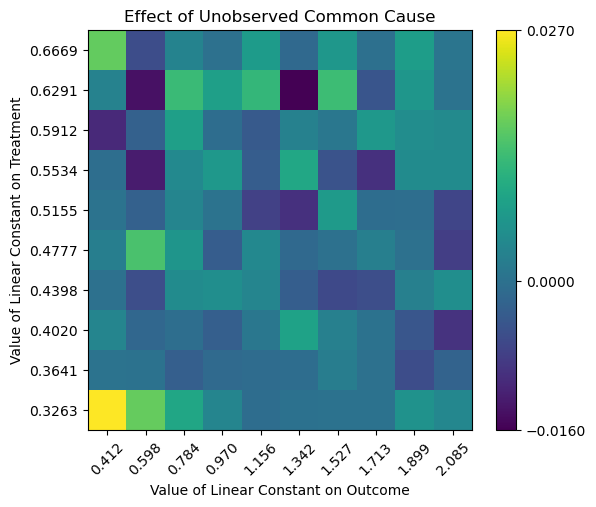

Refute: Add an Unobserved Common Cause
Estimated effect:0.29089376320155225
New effect:(np.float64(-0.016007307764766665), np.float64(0.02698536848485844))



In [21]:
# Run refutation test: Placebo Treatment (Should show NO effect)
refute_placebo = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter")
print(refute_placebo)

# Run refutation test: Bootstrap (Resample Data to Test Stability)
refute_bootstrap = model.refute_estimate(identified_estimand, estimate, method_name="bootstrap_refuter")
print(refute_bootstrap)

# Run refutation test: Adding Unobserved Confounders
refute_unobserved = model.refute_estimate(identified_estimand, estimate, method_name="add_unobserved_common_cause")
print(refute_unobserved)


### Extra Placebo Tests
Here, we test if the model predicts an effect for placebo outcomes (outcomes that shouldn't be affected by the treatment).

Expected Outcome:
- If the treatment effect is insignificant (p > 0.05), the model is valid.
- If the treatment affects a random variable, the model might have confounding issues

In [16]:
# Define a placebo outcome (e.g., something unrelated to study hours)
df_encoded['placebo_outcome'] = np.random.normal(50, 10, df_encoded.shape[0])

# Fit the same causal inference model
placebo_model = OLS(df_encoded['placebo_outcome'], add_constant(df_encoded['treatment'])).fit()

# Display results
print(placebo_model.summary())

                            OLS Regression Results                            
Dep. Variable:        placebo_outcome   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.3793
Date:                Sun, 23 Feb 2025   Prob (F-statistic):              0.538
Time:                        11:52:41   Log-Likelihood:                -23792.
No. Observations:                6378   AIC:                         4.759e+04
Df Residuals:                    6376   BIC:                         4.760e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         49.9811      0.185    270.244      0.0

## Usage of the model

### Estimate Individual Treatment Effects (ITE)
Predict how much an individual’s exam score would improve if they studied more.

##### Use case: Personalize recommendations for students.

In [34]:
# Ensure no missing values
df_encoded = df_encoded.dropna(subset=['Hours_Studied'])

# Ensure correct data types
df_encoded['Hours_Studied'] = df_encoded['Hours_Studied'].astype(float)

# Add constant manually
df_encoded['const'] = 1
X_pred = df_encoded[['const', 'Hours_Studied']]

# Ensure median counterfactual is structured correctly
median_hours_studied = df_encoded['Hours_Studied'].median()
X_median = pd.DataFrame({'const': [1], 'Hours_Studied': [median_hours_studied]})

# Compute Individual Treatment Effect (ITE)
df_encoded['individual_effect'] = (
    weighted_model.predict(X_pred) - weighted_model.predict(X_median).item()
)

# Show results
df_encoded[['Hours_Studied', 'Exam_Score', 'individual_effect']].head()

,Hours_Studied,Exam_Score,individual_effect
0,23.0,67,0.873233
1,19.0,61,-0.291078
2,24.0,74,1.164311
3,29.0,71,2.619700
4,19.0,70,-0.291078


### Policy Simulations

Simulate how increasing study hours affects average student scores.

#### Use case: Predict the impact of policy interventions (e.g., mandating study programs).

In [31]:
# Simulate increasing study hours by + 20
df_encoded['Hours_Studied_new'] = df_encoded['Hours_Studied'] + 20
df_encoded['predicted_score_new'] = weighted_model.predict(add_constant(df_encoded['Hours_Studied_new']))

# Compare the difference
df_encoded['score_difference'] = df_encoded['predicted_score_new'] - df_encoded['Exam_Score']

# Show results
print(df_encoded[['Hours_Studied', 'Hours_Studied_new', 'Exam_Score', 'predicted_score_new', 'score_difference']].head())

   Hours_Studied  Hours_Studied_new  Exam_Score  predicted_score_new  \
0             23                 43          67            73.953567   
1             19                 39          61            72.789257   
2             24                 44          74            74.244645   
3             29                 49          71            75.700034   
4             19                 39          70            72.789257   

   score_difference  
0          6.953567  
1         11.789257  
2          0.244645  
3          4.700034  
4          2.789257  


### Counterfactual Analysis

Estimate what would have happened if a student had studied 5 more hours.

#### Use case: Help students optimize their study strategies.

In [37]:
student_idx = 10  # Example student

# Create a new column for counterfactual study hours
df_encoded.loc[student_idx, 'Hours_Studied_cf'] = df_encoded.loc[student_idx, 'Hours_Studied'] + 5

# Ensure counterfactual input is a properly structured DataFrame with a constant term
X_cf = pd.DataFrame({'const': [1], 'Hours_Studied': [df_encoded.loc[student_idx, 'Hours_Studied_cf']]})

# Predict counterfactual exam score
predicted_cf_score = weighted_model.predict(X_cf)

# Print results
print(f"Actual Exam Score: {df_encoded.loc[student_idx, 'Exam_Score']}")
print(f"Counterfactual Exam Score (if studied 5 more hours): {predicted_cf_score[0]}")

Actual Exam Score: 68
Counterfactual Exam Score (if studied 5 more hours): 67.8409352203102
